<a href="https://colab.research.google.com/github/Sung-Minsoek/Lego-Disassembler/blob/main/colab/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /drive/directory

/content/drive/Shareddrives/Vision_Team_Project


In [ ]:
!pip3 install einops
!pip3 install pytorchvideo
!pip install torchinfo

# Init


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pickle
import time
import pytorchvideo
from pytorchvideo import transforms
import torch
import torch.optim as optim
import torchvision
from torchvision.transforms import v2
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data.dataset import TensorDataset
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data.dataset import TensorDataset

from torch import nn, einsum
import torch.nn.functional as F
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

import math
from functools import partial
from sklearn.model_selection import train_test_split

random.seed(10)
np.random.seed(123)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
data_path = '/to/data/data_Reg.npy' # data path
labels_path = '/to/data/labels_Reg.csv' #label path

In [ ]:
params = {
    'optimizer'     : None,
    'loss_function' : None,
    'scheduler'     : None,
    'stats'         : [[0.5], [0.25]],
    'batch_size'    : 128,
    'worker'        : 4,
    'epochs'        : 100,
    'momentum'      : 0.9,
    'wd_decay'      : 0.0005,
    'lr'            : 0.00005,
    'train_size'    : 0.9,
    'valid_size'    : 0.1,
    'milestones'    : [],       # For Step lr scheduler
    'dropout'       : 0.5,      # For Dropout
    'patience'      : 10,        # For Early Stopping
    'device'        : 'cuda'    # 'cuda' = use cuda
}

# Data Load

In [ ]:
data = np.load(data_path)

In [ ]:
labels_df = pd.read_csv(labels_path)

In [ ]:
data = torch.from_numpy(data)

In [ ]:
labels = np.array(labels_df.values[:,1:])
labels = labels.astype(np.float32)
labels = torch.from_numpy(labels)

In [ ]:
print(data.shape)
print(labels.shape)

torch.Size([10000, 1, 4, 256, 256])
torch.Size([10000, 7])


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None, no_labels=False):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.no_labels = no_labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.no_labels == True:
            image = self.data[idx]
            if self.transform:
                image = self.transform(image)
            return image

        else:
            image = self.data[idx]
            label = self.labels[idx]
            if self.transform:
                image = self.transform(image)
            return image, label

In [ ]:
train_transforms = v2.Compose([
    v2.Resize((224, 224), antialias=False),
    v2.RandomHorizontalFlip(),
    v2.RandomCrop((224, 224), padding=16),
    v2.ToDtype(torch.float32),
    v2.Normalize((0.45,), (0.225,))
])

valid_transforms = v2.Compose([
    v2.ToDtype(torch.float32),
    v2.Normalize((0.45,), (0.225,))
])

In [ ]:
dataset_size = len(data)
trainset_size = int(dataset_size * params['train_size'])
validset_size = int(dataset_size * params['valid_size'])

In [ ]:
train_data, valid_data, train_labels, valid_labels = train_test_split(data, labels, test_size=params['valid_size'], random_state=10)

In [ ]:
train_dataset = CustomDataset(train_data, train_labels, transform=train_transforms)
trainloader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, num_workers=params['worker'])

valid_dataset = CustomDataset(valid_data, valid_labels, transform=valid_transforms)
validloader = DataLoader(valid_dataset, batch_size=params['batch_size'], shuffle=False, num_workers=params['worker'])

# View Image

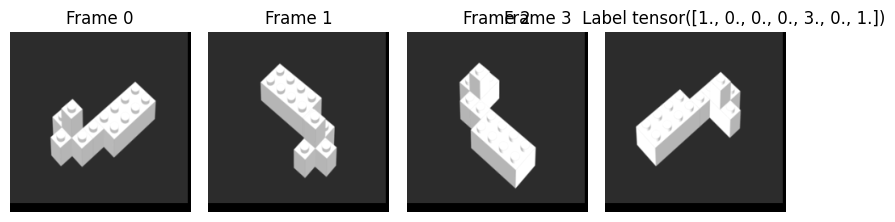

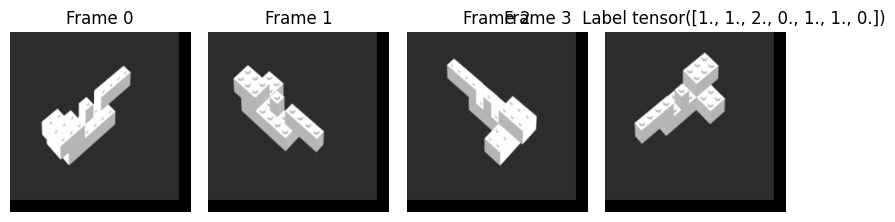

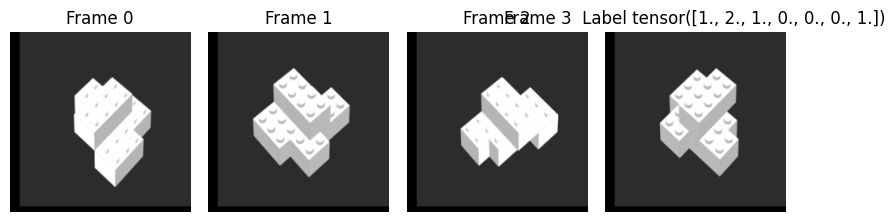

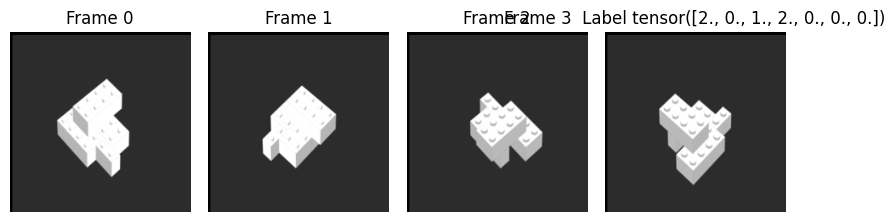

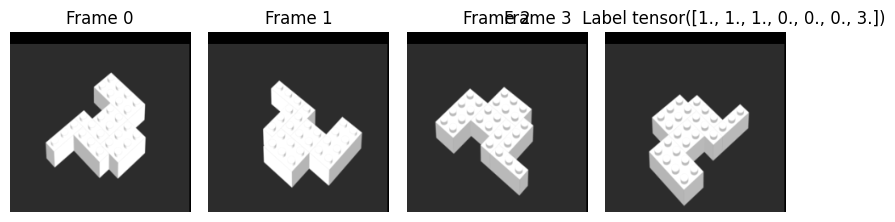

In [ ]:
dataiter = iter(trainloader)
videos_1, labels_1 = next(dataiter)

for i in range(5):
    video_1 = videos_1[i, 0, :, :, :]
    label_1 = labels_1[i]

    fig, axes = plt.subplots(1, 4, figsize=(10, 4))
    plt.subplots_adjust(wspace=0.1)

    frame1 = video_1[0, :, :]
    frame2 = video_1[1, :, :]
    frame3 = video_1[2, :, :]
    frame4 = video_1[3, :, :]

    axes[0].imshow(frame1.squeeze(), cmap='gray')
    axes[0].axis('off')
    axes[0].set_title(f'Frame {0}')

    axes[1].imshow(frame2.squeeze(), cmap='gray')
    axes[1].axis('off')
    axes[1].set_title(f'Frame {1}')

    axes[2].imshow(frame3.squeeze(), cmap='gray')
    axes[2].axis('off')
    axes[2].set_title(f'Frame {2}')

    axes[3].imshow(frame4.squeeze(), cmap='gray')
    axes[3].axis('off')
    axes[3].set_title(f'Frame {3}  Label {label_1}')

    plt.show()

# ResNet3d : P-basic-LegoGPT

In [ ]:
def get_inplanes():
    return [64, 128, 256, 512]


def conv3x3x3(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=(1, stride, stride),
                     padding=1,
                     bias=False)


def conv1x1x1(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=(1, stride, stride),
                     bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv3x3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv1x1x1(in_planes, planes)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = conv3x3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = conv1x1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm3d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,
                 block,
                 layers,
                 block_inplanes,
                 n_input_channels=1,
                 conv1_t_size=3,
                 conv1_t_stride=1,
                 no_max_pool=False,
                 shortcut_type='B',
                 widen_factor=1.0,
                 n_classes=7):
        super().__init__()

        block_inplanes = [int(x * widen_factor) for x in block_inplanes]

        self.in_planes = block_inplanes[0]
        self.no_max_pool = no_max_pool

        self.conv1 = nn.Conv3d(n_input_channels,
                               self.in_planes,
                               kernel_size=(conv1_t_size, 7, 7),
                               stride=(conv1_t_stride, 2, 2),
                               padding=(conv1_t_size // 2, 3, 3),
                               bias=False)
        self.bn1 = nn.BatchNorm3d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=1)
        self.layer1 = self._make_layer(block, block_inplanes[0], layers[0],
                                       shortcut_type)
        self.layer2 = self._make_layer(block,
                                       block_inplanes[1],
                                       layers[1],
                                       shortcut_type,
                                       stride=2)
        self.layer3 = self._make_layer(block,
                                       block_inplanes[2],
                                       layers[2],
                                       shortcut_type,
                                       stride=2)
        self.layer4 = self._make_layer(block,
                                       block_inplanes[3],
                                       layers[3],
                                       shortcut_type,
                                       stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.dropout = nn.Dropout(params['dropout'])
        self.fc = nn.Linear(block_inplanes[3] * block.expansion, n_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _downsample_basic_block(self, x, planes, stride):
        out = F.avg_pool3d(x, kernel_size=1, stride=stride)
        zero_pads = torch.zeros(out.size(0), planes - out.size(1), out.size(2),
                                out.size(3), out.size(4))
        if isinstance(out.data, torch.cuda.FloatTensor):
            zero_pads = zero_pads.cuda()

        out = torch.cat([out.data, zero_pads], dim=1)

        return out

    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(self._downsample_basic_block,
                                     planes=planes * block.expansion,
                                     stride=stride)
            else:
                downsample = nn.Sequential(
                    conv1x1x1(self.in_planes, planes * block.expansion, stride),
                    nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(
            block(in_planes=self.in_planes,
                  planes=planes,
                  stride=stride,
                  downsample=downsample))
        self.in_planes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if not self.no_max_pool:
            x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)

        return x


def generate_model(model_depth, **kwargs):
    assert model_depth in [10, 18, 34, 50, 101, 152, 200]

    if model_depth == 10:
        model = ResNet(BasicBlock, [1, 1, 1, 1], get_inplanes(), **kwargs)
    elif model_depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], get_inplanes(), **kwargs)
    elif model_depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], get_inplanes(), **kwargs)
    elif model_depth == 152:
        model = ResNet(Bottleneck, [3, 8, 36, 3], get_inplanes(), **kwargs)
    elif model_depth == 200:
        model = ResNet(Bottleneck, [3, 24, 36, 3], get_inplanes(), **kwargs)

    return model

# Model Test: P-basic-LegoGPT

In [ ]:
model = generate_model(50)

file_path = '/to/best_LegoGPT_model'
checkpoint = torch.load(file_path)
model.load_state_dict(checkpoint['model_state_dict'])

# Parameters


In [ ]:
params['loss_function'] = nn.CrossEntropyLoss()
params['optimizer'] = optim.AdamW(params=model.parameters(), lr = params['lr'], weight_decay=params['wd_decay'])
params['scheduler'] = optim.lr_scheduler.OneCycleLR(params['optimizer'], params['lr'], total_steps=params['epochs'] * len(trainloader))

params['optimizer'].load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
summary(model,input_size=(64,1,4,128,128))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 7]                   --
├─Conv3d: 1-1                            [64, 64, 4, 64, 64]       9,408
├─BatchNorm3d: 1-2                       [64, 64, 4, 64, 64]       128
├─ReLU: 1-3                              [64, 64, 4, 64, 64]       --
├─MaxPool3d: 1-4                         [64, 64, 4, 32, 32]       --
├─Sequential: 1-5                        [64, 256, 4, 32, 32]      --
│    └─Bottleneck: 2-1                   [64, 256, 4, 32, 32]      --
│    │    └─Conv3d: 3-1                  [64, 64, 4, 32, 32]       4,096
│    │    └─BatchNorm3d: 3-2             [64, 64, 4, 32, 32]       128
│    │    └─ReLU: 3-3                    [64, 64, 4, 32, 32]       --
│    │    └─Conv3d: 3-4                  [64, 64, 4, 32, 32]       110,592
│    │    └─BatchNorm3d: 3-5             [64, 64, 4, 32, 32]       128
│    │    └─ReLU: 3-6                    [64, 64, 4, 32, 32]       --
│

# Train

In [ ]:
params['loss_function'] = nn.MSELoss()
params['optimizer'] = optim.AdamW(params=model.parameters(), lr = params['lr'], weight_decay=params['wd_decay'])
params['scheduler'] = optim.lr_scheduler.OneCycleLR(params['optimizer'], params['lr'], total_steps=params['epochs'] * len(trainloader))

In [ ]:
def test_with_labels_for_classification(model, testloader):
    val_correct = 0
    val_total = 0

    total_loss = 0.0
    num_samples = 0

    Top_3 = 0
    criterion = params['loss_function']
    model.eval()

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)

            total_loss += loss * images.size(0)
            num_samples += images.size(0)

    mean_loss = total_loss / num_samples

    return mean_loss

In [ ]:
epoch_plt = [0]
train_plt = [0]
valid_plt = [0]

def train(model, trainloader, validloader, params):


    device = params['device']

    optimizer = params['optimizer']
    criterion = params['loss_function']
    scheduler = params['scheduler']

    model.train()

    for epoch in range(params['epochs']):
        running_loss = 0.0
        num_samples = 0

        start_time = time.time()

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.cuda.amp.autocast(True):
                output = model(inputs)
            output = output.type(torch.float32)

            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()
            num_samples += inputs.size(0)

            end_time = time.time()
            time_taken = end_time - start_time
            time_taken = str(time_taken/60).split('.')

        valid_loss = test_with_labels_for_classification(model, validloader)

        epoch_plt.append(epoch + 1)
        train_plt.append(min(0.05, running_loss / num_samples))
        valid_plt.append(min(5, valid_loss.cpu()))

        print('Epoch: {}/{}, train_loss: {:.4f}, valid_loss: {:.2f}, time:{}m {}s'.format(epoch + 1, params['epochs'], running_loss / num_samples, valid_loss, time_taken[0], time_taken[1][:2]))

    fig, ax1 = plt.subplots()
    ax1.plot(epoch_plt, train_plt, color = 'red', alpha = 0.5, label='Train loss')

    ax2 = ax1.twinx()
    ax2.plot(epoch_plt, valid_plt, color = 'blue', alpha = 0.5, label='Valid loss')

    plt.show()

    return model

Epoch: 1/100, train_loss: 0.1048, valid_loss: 9.41, time:0m 52s
Epoch: 2/100, train_loss: 0.0188, valid_loss: 1.19, time:0m 50s
Epoch: 3/100, train_loss: 0.0084, valid_loss: 0.93, time:0m 50s
Epoch: 4/100, train_loss: 0.0063, valid_loss: 0.68, time:0m 50s
Epoch: 5/100, train_loss: 0.0054, valid_loss: 0.67, time:0m 50s
Epoch: 6/100, train_loss: 0.0053, valid_loss: 0.66, time:0m 50s
Epoch: 7/100, train_loss: 0.0053, valid_loss: 0.66, time:0m 50s
Epoch: 8/100, train_loss: 0.0053, valid_loss: 0.66, time:0m 50s
Epoch: 9/100, train_loss: 0.0053, valid_loss: 0.66, time:0m 50s
Epoch: 10/100, train_loss: 0.0053, valid_loss: 0.66, time:0m 50s
Epoch: 11/100, train_loss: 0.0053, valid_loss: 0.66, time:0m 50s
Epoch: 12/100, train_loss: 0.0053, valid_loss: 0.66, time:0m 50s
Epoch: 13/100, train_loss: 0.0053, valid_loss: 0.66, time:0m 50s
Epoch: 14/100, train_loss: 0.0053, valid_loss: 0.66, time:0m 50s
Epoch: 15/100, train_loss: 0.0053, valid_loss: 0.66, time:0m 50s
Epoch: 16/100, train_loss: 0.0053,

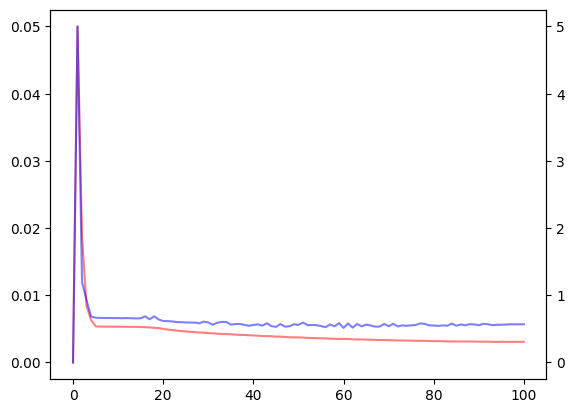

In [ ]:
model = train(model, trainloader, validloader, params)

In [ ]:
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': params['optimizer'].state_dict(),
    'scheduler_state_dict': params['scheduler'].state_dict(),
}

torch.save(checkpoint, '/to/best_Lego_Regression')

# Load train_model

In [ ]:
file_path = '/to/best_Lego_Regression'
checkpoint = torch.load(file_path)
model.load_state_dict(checkpoint['model_state_dict'])

# Test

In [ ]:
def test_with_labels_for_acc(model, testloader):
    val_correct = 0
    val_correctv2 = 0

    val_total = 0

    total_loss = 0.0
    num_samples = 0

    Top_3 = 0
    Top_3v2 = 0

    best_index = 0

    blocks_per_index = [0, 0, 0, 0, 0, 0, 0]
    blocks_per_indexv2 = [0, 0, 0, 0, 0, 0, 0]

    criterion = params['loss_function']
    model.eval()

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            best_index = -1

            for i in range(outputs.shape[0]):
              Top_3 = 0
              Top_3v2 = 0
              for j in range(outputs.shape[1]):
                if labels[i][j] - outputs[i][j] < 0.5 and  labels[i][j] - outputs[i][j] >= -0.5:
                  Top_3 += 1
                  blocks_per_index[j] += 1
                if labels[i][j] - outputs[i][j] < 1.5 and  labels[i][j] - outputs[i][j] >= -1.5:
                  Top_3v2 += 1
                  blocks_per_indexv2[j] += 1

              if Top_3 >= 7:
                val_correct += 1
              if Top_3v2 >= 7:
                val_correctv2 += 1
              if Top_3v2 == 7:
                best_index = i

            val_total += labels.size(0)


            loss = criterion(outputs, labels)

            total_loss += loss * images.size(0)
            num_samples += images.size(0)

            if best_index > 0:
              primg = data[0][best_index]
              prlab = data[1][best_index]
              prout = outputs[best_index]
              prout = prout.cpu()
              prout = np.round(prout)

              video = images[best_index, 0, :, :, :]
              label = labels[best_index]
              video = video.cpu()
              label = label.cpu()

              fig, axes = plt.subplots(1, 4, figsize=(10, 4))
              plt.subplots_adjust(wspace=0.1)

              frame1 = video[0, :, :]
              frame2 = video[1, :, :]
              frame3 = video[2, :, :]
              frame4 = video[3, :, :]

              axes[0].imshow(frame1.squeeze(), cmap='gray')
              axes[0].axis('off')
              axes[0].set_title(f'Frame {0}')

              axes[1].imshow(frame2.squeeze(), cmap='gray')
              axes[1].axis('off')
              axes[1].set_title(f'Frame {1}')

              axes[2].imshow(frame3.squeeze(), cmap='gray')
              axes[2].axis('off')
              axes[2].set_title(f'Frame {2}')

              axes[3].imshow(frame4.squeeze(), cmap='gray')
              axes[3].axis('off')
              axes[3].set_title(f'Frame {3}')

              plt.show()

              print(label, prout)

    mean_loss = total_loss / num_samples
    print("loss: ",mean_loss)

    print("+-0.5: ",val_correct,val_total)
    print(blocks_per_index)

    print("+-1.5: ", val_correctv2,val_total)
    print(blocks_per_indexv2)

    return val_correct / val_total, val_correctv2 / val_total,  mean_loss

In [ ]:
test_with_labels_for_acc(model, validloader)